In [1]:
#Importing libraries needed
import pandas as pd
import numpy as np


#For visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import shap

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import svm, datasets
from sklearn import metrics


# For demonstrative purposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# How Do Wind Speed Features Impact Model Performance
For the scope of this project we are particularly interested in how hurricane's impact real estate value. Using wind speed we were able to gauge how much damage a hurricane had on a certain area. The most important feature for our best model was the fastest 2 minute wind gust and SizeRank. When we drop the wind features from the model the accuracy drops to 0.98 and the F1 score drops to 0.96. Meaning that wind features do improve model performance. 

| Model | Accuracy | F1 |  AUC |
|-- | -- | -- | -- |
| No Wind | 0.98 | 0.96 | 0.99 |   
| Just Wind | 0.96 | 0.91 |  0.98 |    
| Just Wind (Tuned) | 0.78 | 0.56 |  0.80 | 



## Obtaining the Data 

For this part of the process I will use the dataset containing all homes. 

In [2]:
#opening dataset 
all_df = pd.read_csv(r'data\wind_modeling.csv')
all_df.describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,14.046948,27.354942,1359.034884,196091.514509,219108.234733,13.783402,0.250000
std,7.013264,12.690591,3021.571059,118770.632169,126637.076629,8.838321,0.433643
min,2.910000,0.000000,12.000000,44457.567490,52157.021900,-4.161603,0.000000
25%,8.720000,18.100000,106.000000,101212.031625,122666.923050,6.526272,0.000000
50%,12.750000,23.900000,233.000000,168065.082200,188091.092300,11.638427,0.000000
75%,17.220000,31.325000,916.000000,257806.739650,286217.803975,19.627916,0.250000
max,40.710000,79.000000,12877.000000,638691.713200,669502.004200,38.720009,1.000000


# Running the Model Without Wind Features

In [3]:
#initiating model
xgb = XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

In [4]:
#y is prediction variable 
#X is features 
y_boost = all_df['increase']
X_boost = all_df.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2', 'AWND'], axis=1)


### Train/Test Split

In [5]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [6]:
#fitting the model 
xgb.fit(XG_X_train, XG_y_train);

In [7]:
#getting predictions 
y_pred_train = xgb.predict(XG_X_train)

In [8]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 0.996


In [9]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 0.992


### Testing Data

In [10]:
#fitting the model 
xgb.fit(XG_X_test, XG_y_test);

In [11]:
#getting predictions 
y_pred_test = xgb.predict(XG_X_test)

In [12]:
#Printing Accuracy
accuracy_XG_nowind = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG_nowind)

0.9807692307692307


In [13]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG_nowind = f1_score(XG_y_test, y_pred_test)
print(F1_XG_nowind)

0.96


In [14]:
model_dict = {}
model_dict['XGBoost Accuracy No Wind'] = accuracy_XG_nowind
model_dict['XGBoost F1 No Wind'] = F1_XG_nowind
model_dict

{'XGBoost Accuracy No Wind': 0.9807692307692307, 'XGBoost F1 No Wind': 0.96}

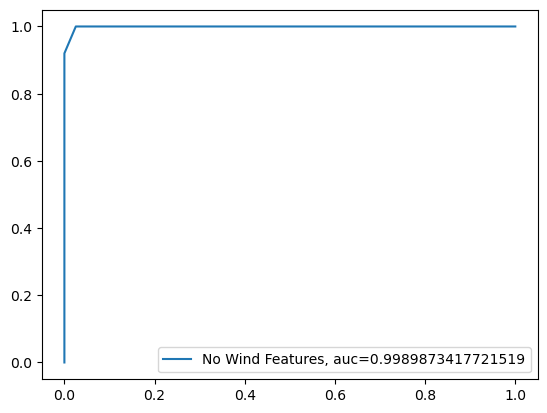

In [15]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="No Wind Features, auc="+str(auc))
plt.legend(loc=4)
plt.show()

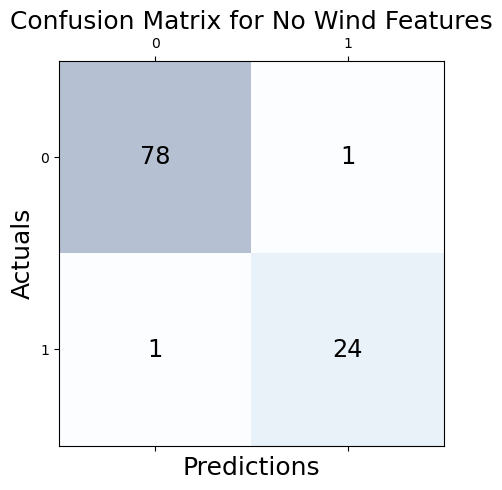

In [16]:
#plotting confusion matrix 
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for No Wind Features', fontsize=18)
plt.show()

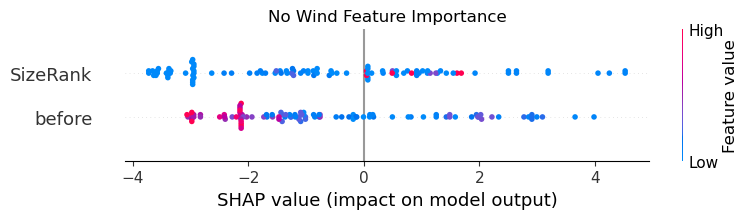

In [17]:
#Using SHAP to assess feature importance 
# creating an explainer for our model
explainer = shap.TreeExplainer(xgb)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(XG_X_test)

#creating a beeswarm plot 
shap.initjs()
plt.title("No Wind Feature Importance", y=1)
shap.summary_plot(shap_values, XG_X_test)

## XGBoost on Just Wind Features

Let's see our results using just wind as a feature.  

### Selecting Our Target Variable and Features

In [18]:
#y is prediction variable 
#X is features 
y_boost = all_df['increase']
X_boost = all_df.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'SizeRank', 'before'], axis=1)


### Train/Test Split

In [19]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [20]:
#fitting model 
xgb.fit(XG_X_train, XG_y_train);

In [21]:
#getting predictions 
y_pred_train = xgb.predict(XG_X_train)

In [22]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 0.933


In [23]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 0.857


### Testing Data

In [24]:
#fitting the model 
xgb.fit(XG_X_test, XG_y_test);

In [25]:
#getting predictions 
y_pred_test = xgb.predict(XG_X_test)

In [26]:
#Printing Accuracy
accuracy_XG_justwind = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG_justwind)

0.9615384615384616


In [27]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG_justwind = f1_score(XG_y_test, y_pred_test)
print(F1_XG_justwind)

0.9166666666666666


In [28]:
model_dict['XGBoost Accuracy Just Wind'] = accuracy_XG_justwind
model_dict['XGBoost F1 Just Wind'] = F1_XG_justwind
model_dict

{'XGBoost Accuracy No Wind': 0.9807692307692307,
 'XGBoost F1 No Wind': 0.96,
 'XGBoost Accuracy Just Wind': 0.9615384615384616,
 'XGBoost F1 Just Wind': 0.9166666666666666}

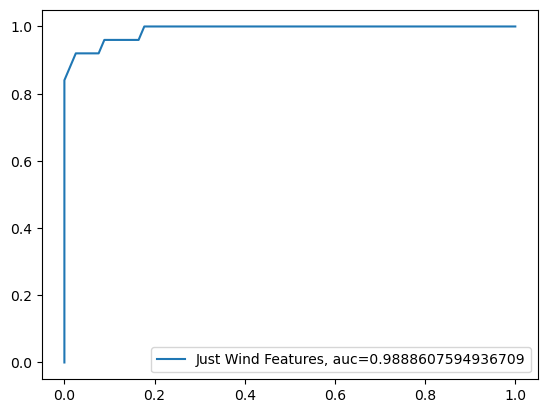

In [29]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Just Wind Features, auc="+str(auc))
plt.legend(loc=4)
plt.show()

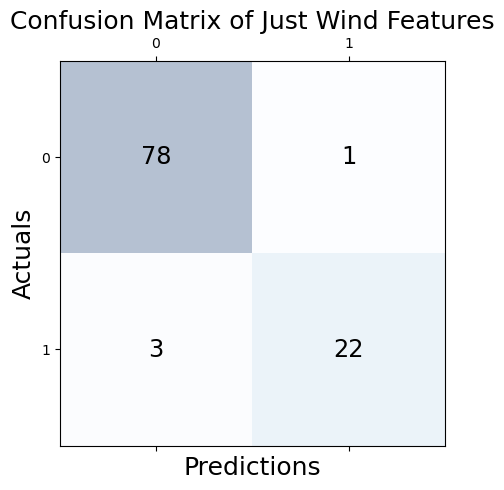

In [30]:
#plotting confusion matrix 
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Just Wind Features', fontsize=18)
plt.show()

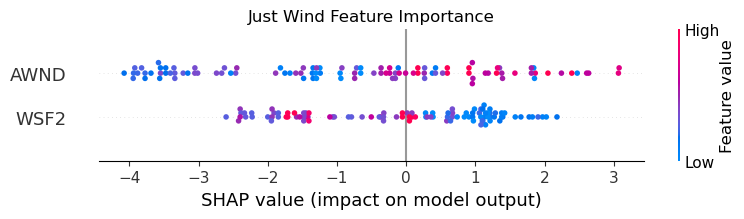

In [31]:
#Using SHAP to assess feature importance 
# creating an explainer for our model
explainer = shap.TreeExplainer(xgb)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(XG_X_test)

#creating a beeswarm plot 
shap.initjs()
plt.title("Just Wind Feature Importance", y=1)
shap.summary_plot(shap_values, XG_X_test)

## XG Boost Tuning

Let's see if we can improve our results using just wind features with model tuning. The optimal parameters according to the gridsearch are:

Best Parameters for Our XGBoost Model:  
{'gamma': 0,  
 'learning_rate': 0.01,  
 'max_depth': 2,  
 'min_child_weight': 1,  
 'n_estimators': 10,  
 'subsample': 0.5}  
 

### Selecting Our Target Variable and Features

In [32]:
#y is prediction variable 
#X is features 
y_boost = all_df['increase']
X_boost = all_df.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'SizeRank', 'before'], axis=1)


### Train/Test/Tune Split

In order to properly tune our model it should be done on data that is not seen during the training or testing process. This will help assure an unbiased model. 70% of our data will be used for training, 15% for testing, and 15% for tuning. 

Works Cited:    
1.Training, Tuning, and Test Datasets. onepager.togaware.com. Accessed July 6, 2023. https://onepager.togaware.com/Training_Tuning_Test_Datase.html


In [33]:
#train/test splits with 30% test size
#half of the test set will be used to create the set we will be tuning on 
XG_X_train, XG_X_test_tune, XG_y_train, XG_y_test_tune = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

In [34]:
#train/test splits with 30% test size
XG_X_test, XG_X_tune, XG_y_test, XG_y_tune = train_test_split(XG_X_test_tune, XG_y_test_tune, test_size=0.50, random_state=56)

In [35]:
#initiating the model
xgb_gs = XGBClassifier(gamma= 0, learning_rate= 0.01, max_depth= 2, min_child_weight= 1, n_estimators= 10, subsample= 0.5, random_state=56)

### Training Data

In [36]:
#fitting the model 
xgb_gs.fit(XG_X_train, XG_y_train);

In [37]:
#predicting 
y_pred_train = xgb_gs.predict(XG_X_train)

In [38]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 0.746


In [39]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 0.000


### Testing Data

In [40]:
#fitting the model 
xgb_gs.fit(XG_X_test, XG_y_test);

In [41]:
#getting predictions 
y_pred_test = xgb_gs.predict(XG_X_test)

In [42]:
#Printing Accuracy
accuracy_XG_justwind_tuned = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG_justwind_tuned)

0.7884615384615384


In [43]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG_justwind_tuned = f1_score(XG_y_test, y_pred_test)
print(F1_XG_justwind_tuned)

0.56


In [44]:
#adding values to model dictionary
model_dict['XGBoost Accuracy Just Wind Tuned'] = accuracy_XG_justwind_tuned
model_dict['XGBoost F1 Just Wind Tuned'] = F1_XG_justwind_tuned
model_dict

{'XGBoost Accuracy No Wind': 0.9807692307692307,
 'XGBoost F1 No Wind': 0.96,
 'XGBoost Accuracy Just Wind': 0.9615384615384616,
 'XGBoost F1 Just Wind': 0.9166666666666666,
 'XGBoost Accuracy Just Wind Tuned': 0.7884615384615384,
 'XGBoost F1 Just Wind Tuned': 0.56}

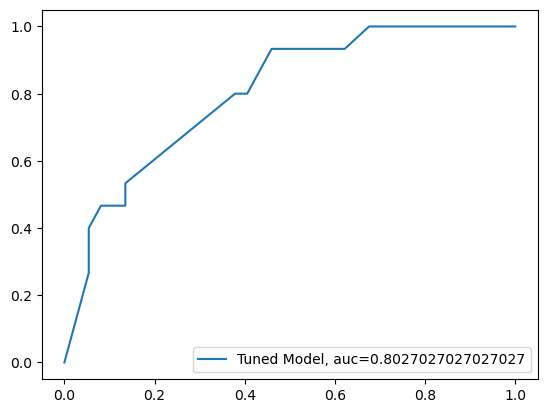

In [45]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb_gs.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Tuned Model, auc="+str(auc))
plt.legend(loc=4)
plt.show()

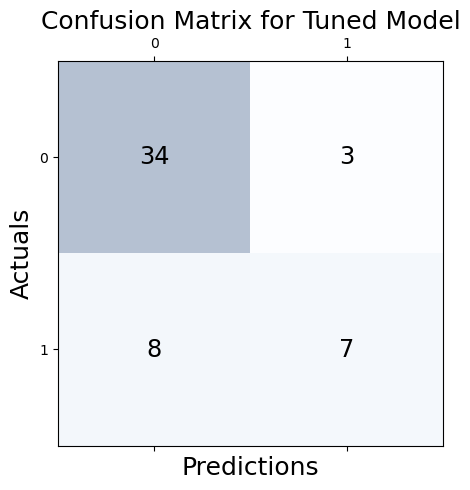

In [46]:
#plotting confusion matrix 
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Tuned Model', fontsize=18)
plt.show()